In [1]:
import sys
sys.path.insert(0, "../../.")

import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pandas as pd
import scipy
from scipy.stats import kstest

from functions.general_functions import b_any_series, inverse_norm, transform_n
from functions.one_dimensional import mac_one_dimension
from functions.eval_functions import pval_mac

from scipy.stats import norm

from seismostats import estimate_b, simulate_magnitudes_binned
%config InlineBackend.figure_format ='retina'

# Fig S1: transformation of b-values

In [2]:
# generate synthetic magnitudes, b-value series and histograms
n_total = 50000
mc = 0
delta_m = 0.1
dates = np.arange(n_total)

# 1
n_m1 = 200
b = 1
mags1 = simulate_magnitudes_binned(n_total, b, mc, delta_m)
b_true1 = np.ones(len(mags1)) * b
b_time1, idx_max1, b_std1 = b_any_series(mags1, dates, n_m= n_m1, mc=mc, delta_m=delta_m, return_std=True, overlap=1, method='tinti')
b_all = estimate_b(mags1, mc, delta_m)

# 2 transform
n_m2 = 500
b_time2 = transform_n(b_time1, b_all,n_m1, n_m2)



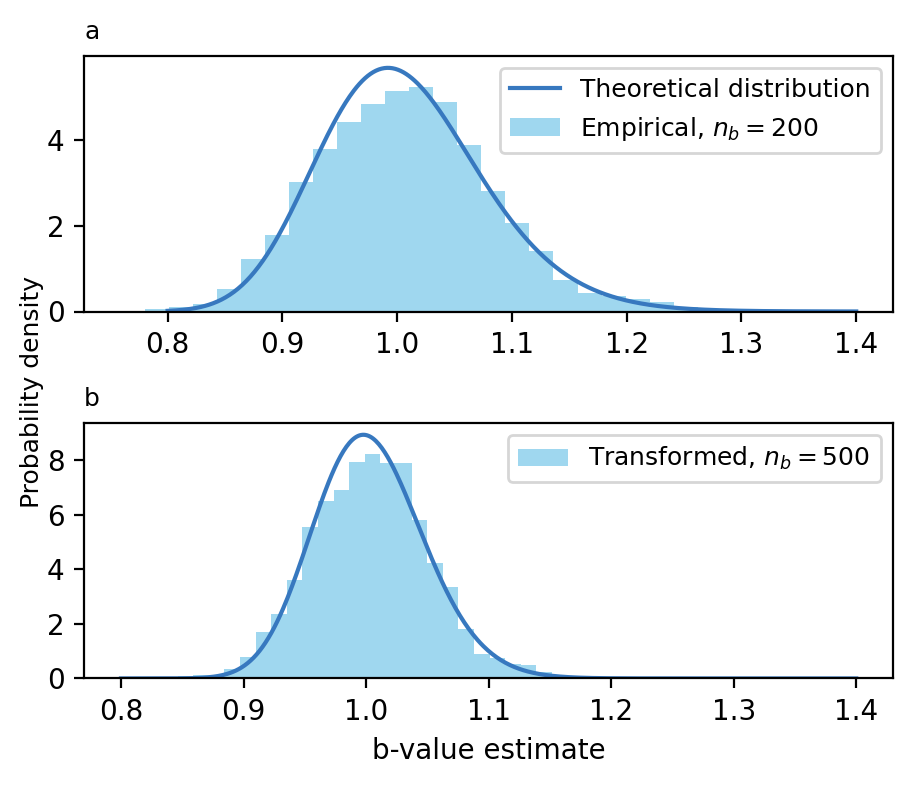

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(4.5, 4))

b_est = np.linspace(0.8, 1.4, 500)

# Create a figure
plt.rcParams.update({'font.size': 9})

ax[0].plot(b_est, inverse_norm(b_est, b_all, n_m1), color = '#3778bf', label='Theoretical distribution')
ax[0].hist(b_time1 , color='skyblue', density=True, label='Empirical, $n_b = 200$', alpha=0.8, bins=30)
ax[0].legend()
ax[0].set_title('a', fontsize=9, loc='left')

ax[1].plot(b_est,inverse_norm(b_est, b_all, n_m2), color = '#3778bf')
ax[1].hist(b_time2 , color='skyblue', density=True, label='Transformed, $n_b = 500$', alpha=0.8, bins=30)
ax[1].legend()
ax[1].set_title('b', fontsize=9, loc='left')

plt.xlabel('b-value estimate')

# put the y label in the middle of the two plots
fig.text(0, 0.5, 'Probability density', va='center', rotation='vertical')

plt.tight_layout()

# Fig S2: scatter plot of p-values of p-values (how uniformly is the original b-significant p-value distributed under the null hypothesis)

In [4]:
n_series = [15, 20, 25, 30, 40, 50, 70, 100, 150, 200, 250, 300]
n_totals = [5000, 10000, 15000, 20000, 25000, 30000, 35000]
bs = [0.7, 1.0, 1.3]

all_permutations = [
    i
    for i in it.product(
        n_series,
        n_totals,
        bs,
    )
]
all_permutations = np.array(all_permutations)

# parameter vectors to run through with cl_idx
cl_n_series = all_permutations[:, 0].astype(int)
cl_n_totals = all_permutations[:, 1].astype(int)
cl_bs = all_permutations[:, 2]

def get_string_data(cutting, transform, cl_idx):
    if cutting == "constant_idx":
        save_str = (
            "results/distributions/cutting_" + str(cutting) + "/"
            "acf_mean_" + str(cl_idx) + ".csv"
        )
    else:
        save_str = (
            "results/distributions/cutting_"
            + str(cutting)
            + "/transform_"
            + str(transform)
            + "/"
            "acf_mean_" + str(cl_idx) + ".csv"
        )
    return save_str


def get_df(cutting, transform):
    all_acfs = []
    all_n_series = []
    all_n_series_used = []
    all_bs = []
    all_n_totals = []

    for cl_idx in range(len(cl_n_series)):

        save_str = get_string_data(cutting, transform, cl_idx)

        try :
            acfs = np.genfromtxt('../'+save_str, delimiter=',')
        except :
            acfs = []
        try :
            n_series_used = np.genfromtxt('../'+save_str.replace("acf_mean", "n_used_mean"), delimiter=',')
        except :
            n_series_used = []
        all_acfs.extend(acfs)
        all_n_series_used.extend(n_series_used)
        all_n_series.extend([cl_n_series[cl_idx]]*len(acfs))
        all_bs.extend([cl_bs[cl_idx]]*len(acfs))
        all_n_totals.extend([cl_n_totals[cl_idx]]*len(acfs))

    # make a dataframe
    df = pd.DataFrame({
        "acf": all_acfs,
        "n_series": all_n_series,
        "n_series_used": all_n_series_used,
        "b": all_bs,
        "n_total": all_n_totals,
    })
    return df

In [5]:
transform = False
cutting = "constant_idx"
df_const = get_df(cutting, transform)

cutting = "random_idx"
transform = True
df_rand = get_df(cutting, transform)

# add column with p-values
df_const['pval'] = pval_mac(df_const['acf'], df_const['n_series_used'], cutting='constant_idx')
df_rand['pval'] = pval_mac(df_rand['acf'], df_rand['n_series_used'], cutting='random_idx')

# estimate if the p-values are uniformly distributed
p_ks_uni_const = []
n_uni_const = []
p_ks_uni_rand = []
n_uni_rand = []

for ii, n_s in enumerate(n_series):
    for jj, n_t in enumerate(n_totals):
        ps = df_const[(df_const['n_total'] == n_t) & (df_const['n_series'] == n_s)]['pval'].values
        p_ks_uni_const.append(kstest(ps,scipy.stats.uniform.cdf).pvalue)
        n_uni_const.append(n_s)
        
        ps = df_rand[(df_rand['n_total'] == n_t) & (df_rand['n_series'] == n_s)]['pval'].values
        p_ks_uni_rand.append(kstest(ps,scipy.stats.uniform.cdf).pvalue)
        n_uni_rand.append(n_s)


/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_69563/2538261628.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  p_ks_uni_rand.append(kstest(ps,scipy.stats.uniform.cdf).pvalue)


Text(0, 0.5, '$p_{ks}$(uniform)')

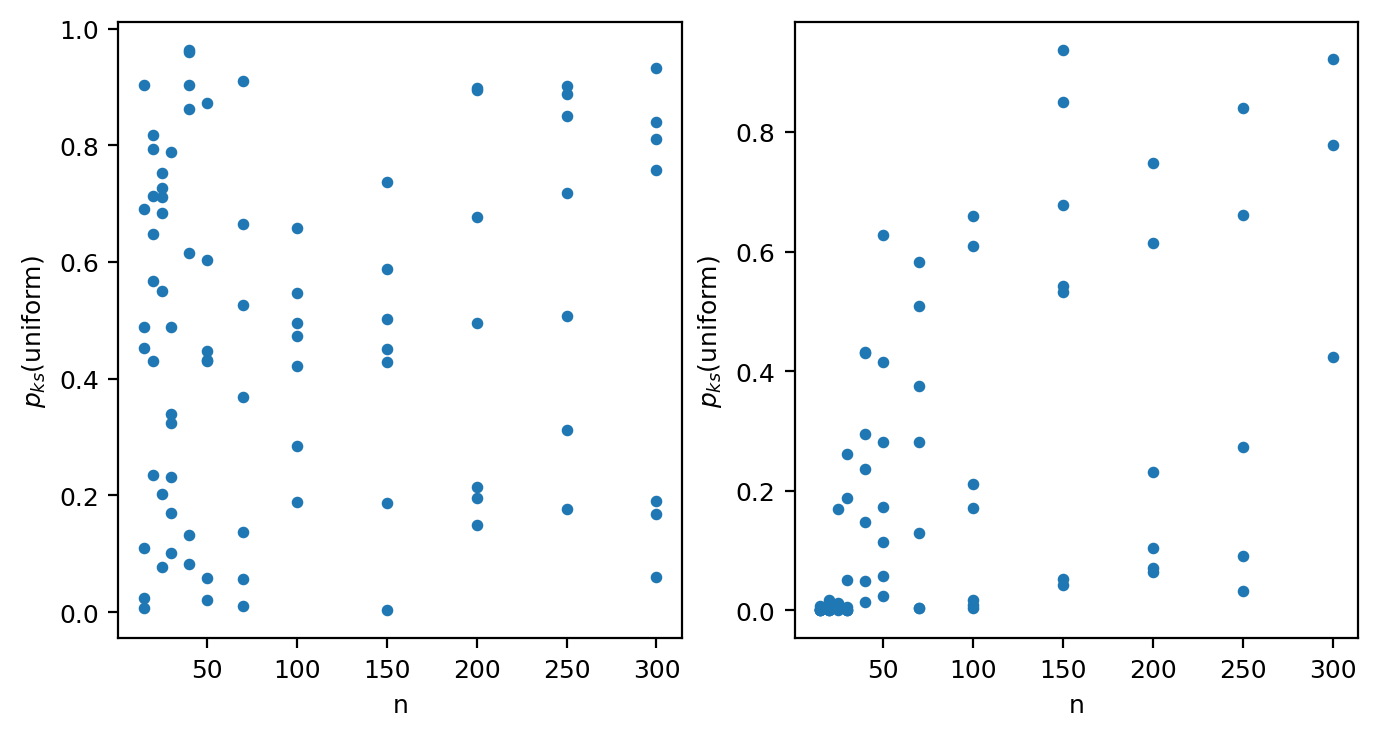

In [6]:
#subplots with two figures
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].scatter(n_uni_const, p_ks_uni_const, s=10)
axs[0].set_xlabel('n')
axs[0].set_ylabel('$p_{ks}$'+'(uniform)')

axs[1].scatter(n_uni_rand, p_ks_uni_rand, s=10)
axs[1].set_xlabel('n')
axs[1].set_ylabel('$p_{ks}$'+'(uniform)')

# Fig S3: Verification of the distribution of the MAC (1D)

In [4]:
# autocorrelation, constant nm
 
n = 10000
n_sample = 15
n_m = 15
mc = 0
delta_m = 0.1
b = 0.5

ac = np.zeros(n)
n_series_used = np.zeros(n)
times =  np.arange(n_sample*n_m)
for ii in range(n):
      magnitudes = simulate_magnitudes_binned(n_sample*n_m, b, mc, delta_m)
      ac[ii], mu_ac, std_ac, _, _ = mac_one_dimension(
            times,
            magnitudes,
            delta_m,
            mc,
            times,
            n_points = n_sample,
            n_realizations=1,
            b_method='tinti',
            transform=False,
            partitioning='constant_idx',
      )


/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/seismostats/analysis/estimate_beta.py:96: UserWarning: no magnitudes in the lowest magnitude bin are present.check if mc is chosen correctly
  warnings.warn(


In [26]:
# MAC, constant nm
 
n = 1000
n_sample = 15
n_m = 15
mc = 0
delta_m = 0.1
b = 0.5

mac = np.zeros(n)
n_series_used = np.zeros(n)
times =  np.arange(n_sample*n_m)
for ii in range(n):
      magnitudes = simulate_magnitudes_binned(n_sample*n_m, b, mc, delta_m)
      mac[ii], mu_mac, std_mac, _, _ = mac_one_dimension(
            times,
            magnitudes,
            delta_m,
            mc,
            times,
            n_points = n_sample,
            n_realizations=100,
            b_method='tinti',
            transform=False,
            partitioning='constant_idx',
      )


/Users/aron/polybox/Projects/b_significant/method_testing/evaluation/../.././functions/one_dimensional.py:129: UserWarning: The number of realizations was too large, leadingto repititions. Therefore it was reduced.
  warnings.warn("The number of realizations was too large, leading"
/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/seismostats/analysis/estimate_beta.py:96: UserWarning: no magnitudes in the lowest magnitude bin are present.check if mc is chosen correctly
  warnings.warn(


In [33]:
# autocorrelation, random nm
 
n = 5000
n_sample = 50
n_m = 30
mc = 0
delta_m = 0.1
b = 0.5

ac_rand = np.zeros(n)
n_series_used = np.zeros(n)
times =  np.arange(n_sample*n_m)
for ii in range(n):
      magnitudes = simulate_magnitudes_binned(n_sample*n_m, b, mc, delta_m)
      ac_rand[ii], mu_ac_rand, std_ac_rand, _, _ = mac_one_dimension(
            times,
            magnitudes,
            delta_m,
            mc,
            times,
            n_points = n_sample,
            n_realizations=1,
            b_method='tinti',
            transform=True,
            partitioning='random_idx',
      )


/Users/aron/polybox/Projects/b_significant/method_testing/evaluation/../.././functions/one_dimensional.py:123: UserWarning: for random_idx, only the average image technique is usable
  warnings.warn("for random_idx, only the average image technique "
/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/seismostats/analysis/estimate_beta.py:96: UserWarning: no magnitudes in the lowest magnitude bin are present.check if mc is chosen correctly
  warnings.warn(
/Users/aron/polybox/Projects/b_significant/method_testing/evaluation/../.././functions/one_dimensional.py:237: RuntimeWarning: invalid value encountered in divide
  b_average = b_average / average_cnt_b
/Users/aron/polybox/Projects/b_significant/method_testing/evaluation/../.././functions/one_dimensional.py:238: RuntimeWarning: invalid value encountered in divide
  std_b_average = std_b_average / average_cnt_b
/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/seismostats/analysis/esti

In [28]:
# MAC, random nm
 
n = 1000
n_sample = 50
n_m = 30
mc = 0
delta_m = 0.1
b = 0.5

mac_rand = np.zeros(n)
n_series_used = np.zeros(n)
times =  np.arange(n_sample*n_m)
for ii in range(n):
      magnitudes = simulate_magnitudes_binned(n_sample*n_m, b, mc, delta_m)
      mac_rand[ii], mu_mac_rand, std_mac_rand, _, _ = mac_one_dimension(
            times,
            magnitudes,
            delta_m,
            mc,
            times,
            n_points = n_sample,
            n_realizations=100,
            b_method='tinti',
            transform=True,
            partitioning='random_idx',
      )


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_69263/3071519270.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax[0,0].plot(x, p, color = '#3778bf', linewidth=1.5, label='$\mathcal{N}(\mu, \sigma)$')
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_69263/3071519270.py:38: SyntaxWarning: invalid escape sequence '\m'
  ax[0,1].plot(x, p, color = '#3778bf', linewidth=1.5, label='$\mathcal{N}(\mu, \sigma)$')


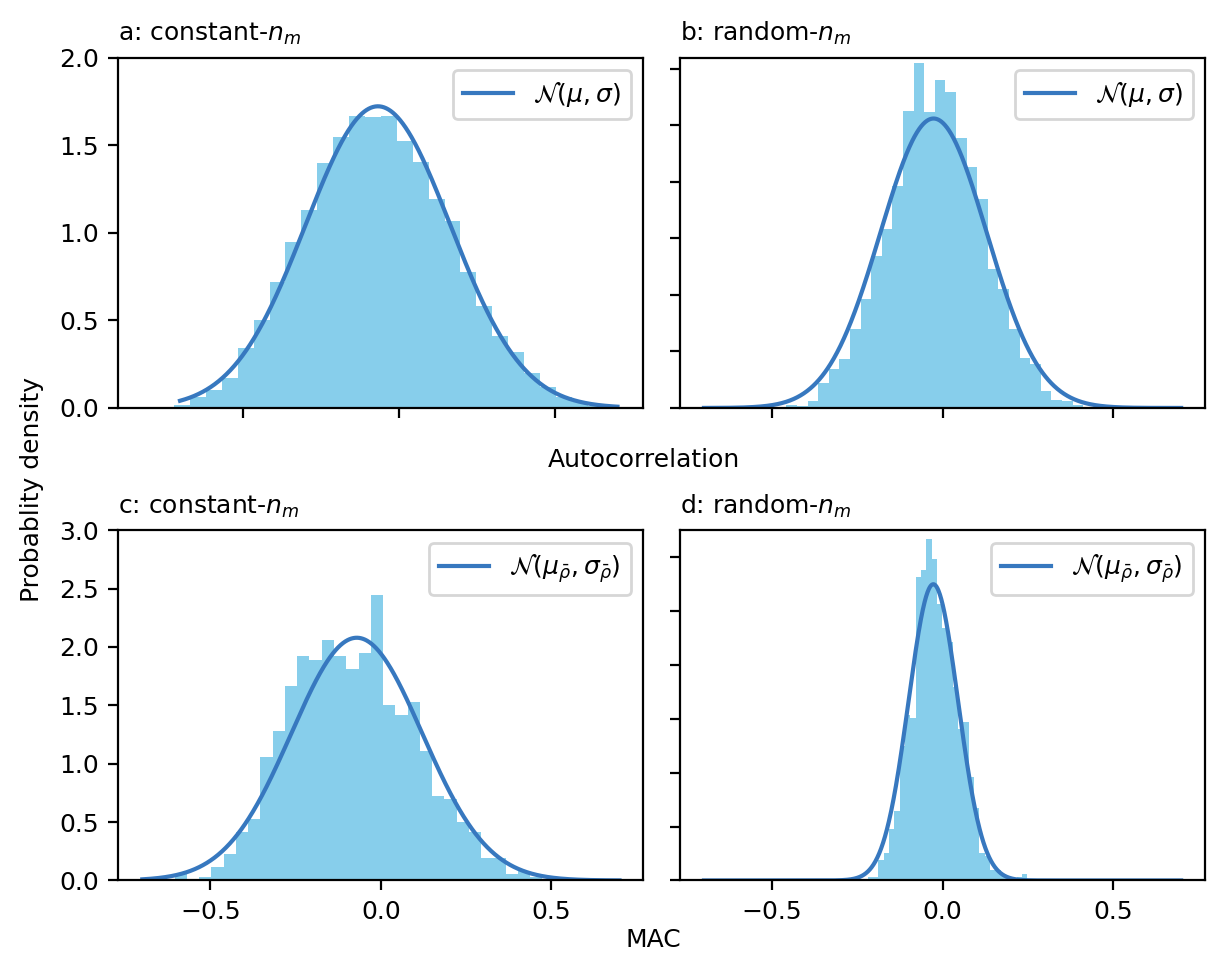

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(6, 5))
# set fontsize
plt.rcParams.update({'font.size': 9})
# set fig size

ax[0,0].hist(ac, density=True, bins=30, color='skyblue')
# plot normal distribution
x = np.linspace(-0.7, 0.7, 1000)
p = norm.pdf(x, mu_ac, std_ac)
ax[0,0].plot(x, p, color = '#3778bf', linewidth=1.5, label='$\mathcal{N}(\mu, \sigma)$')
# set y limit
ax[0,0].set_ylim(0, 2)
ax[0,0].set_xlabel(' ')

ax[0,0].set_title('a: constant-$n_m$', fontsize=9, loc='left')
ax[0,0].set_xticklabels([])
ax[0,0].legend()

#================================================================
#================================================================

ax[1,0].hist(mac, density=True, bins=30, color='skyblue')
# plot normal distribution
p = norm.pdf(x, mu_mac, std_mac)
ax[1,0].plot(x, p, color = '#3778bf', linewidth=1.5, label=r'$\mathcal{N}(\mu_{\bar \rho}, \sigma_{\bar \rho})$')
# set y limit
ax[1,0].set_ylim(0, 3)

ax[1,0].set_xlabel(' ')
ax[1,0].set_title('c: constant-$n_m$', fontsize=9, loc='left')
ax[1,0].legend()

#================================================================
#================================================================
ax[0,1].hist(ac_rand, density=True, bins=30, color='skyblue')
# plot normal distribution
p = norm.pdf(x, mu_ac_rand, std_ac_rand)
ax[0,1].plot(x, p, color = '#3778bf', linewidth=1.5, label='$\mathcal{N}(\mu, \sigma)$')
# set y limit
ax[0,1].set_ylim(0, 3.1)

ax[0,1].set_yticklabels([])
ax[0,1].set_xticklabels([])
ax[0,1].legend()

ax[0,1].set_title('b: random-$n_m$', fontsize=9, loc='left')

#================================================================
#================================================================

ax[1,1].hist(mac_rand, density=True, bins=30, color='skyblue')
# plot normal distribution
p = norm.pdf(x, mu_mac_rand, std_mac_rand)
ax[1,1].plot(x, p, color = '#3778bf', linewidth=1.5, label=r'$\mathcal{N}(\mu_{\bar \rho}, \sigma_{\bar \rho})$')
# set y limit
ax[1,1].set_ylim(0, 6.5)

ax[1,1].set_yticklabels([])
ax[1,1].set_title('d: random-$n_m$', fontsize=9, loc='left')
ax[1,1].legend()

#================================================================
#================================================================

fig.text(-0.01, 0.5, 'Probablity density', va='center', rotation='vertical')
fig.text(0.495, 0.05, 'MAC', va='center')
fig.text(0.43, 0.53, 'Autocorrelation', va='center')



plt.tight_layout()


# Fig S5: Estimation of gamma factor for two partitioning techniques

gamma (constant_idx) =  0.805621102322912


Text(0, 0.5, 'std')

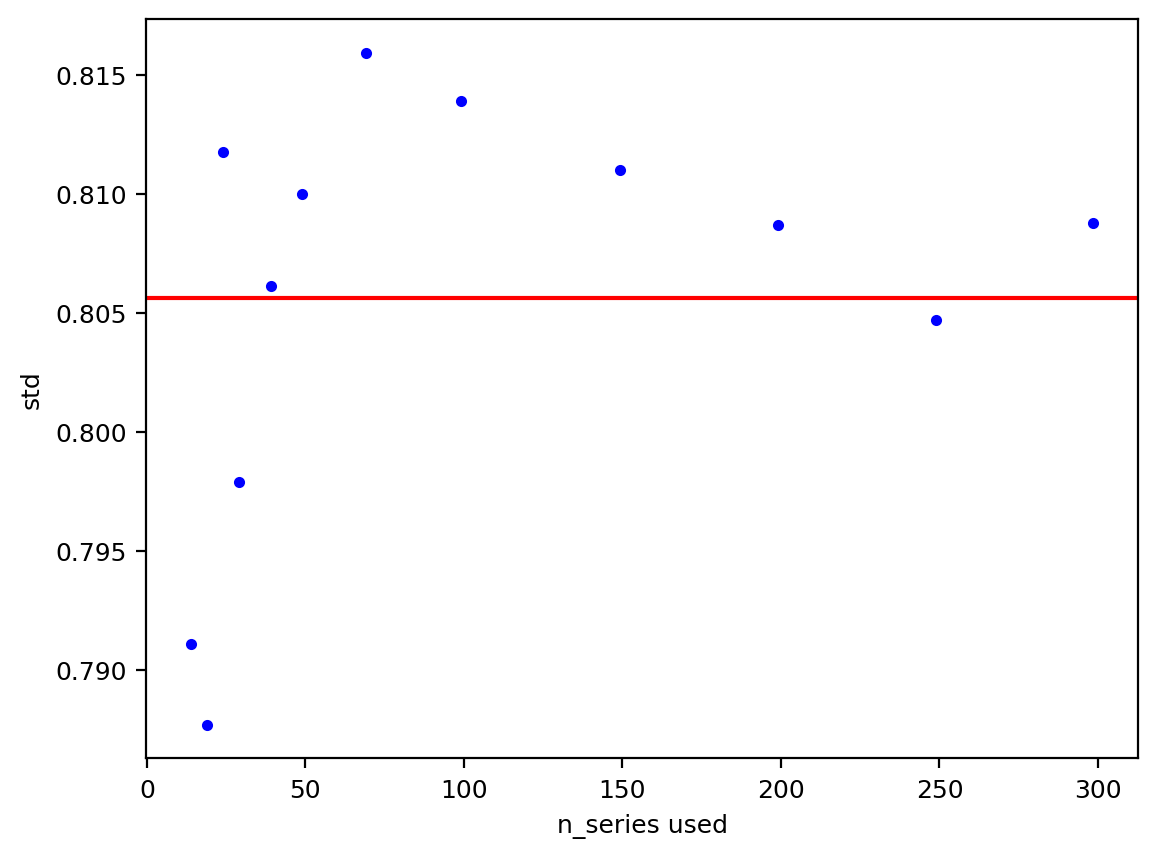

In [7]:
# get the mean value for each group
grouped_mean = df_const[df_const['n_series'] >= 15].groupby('n_series').mean()
grouped_std = df_const[df_const['n_series'] >= 15].groupby('n_series').std()

# estimate the std (which however, uses the n_series_used, the actual number of series used)
x = grouped_mean['n_series_used']
std = (x-2) / (x*np.sqrt(x-1))
normalized = grouped_std['acf'].values / std

# least squares
gamma = np.mean(normalized)
print('gamma (constant_idx) = ', gamma)


plt.plot(x, normalized, color='blue', marker='o', linestyle='', markersize=3)
plt.axhline(y=gamma, color='red')

plt.xlabel("n_series used")
plt.ylabel("std")

gamma (random_idx) =  0.4554834807310068


Text(0, 0.5, 'std')

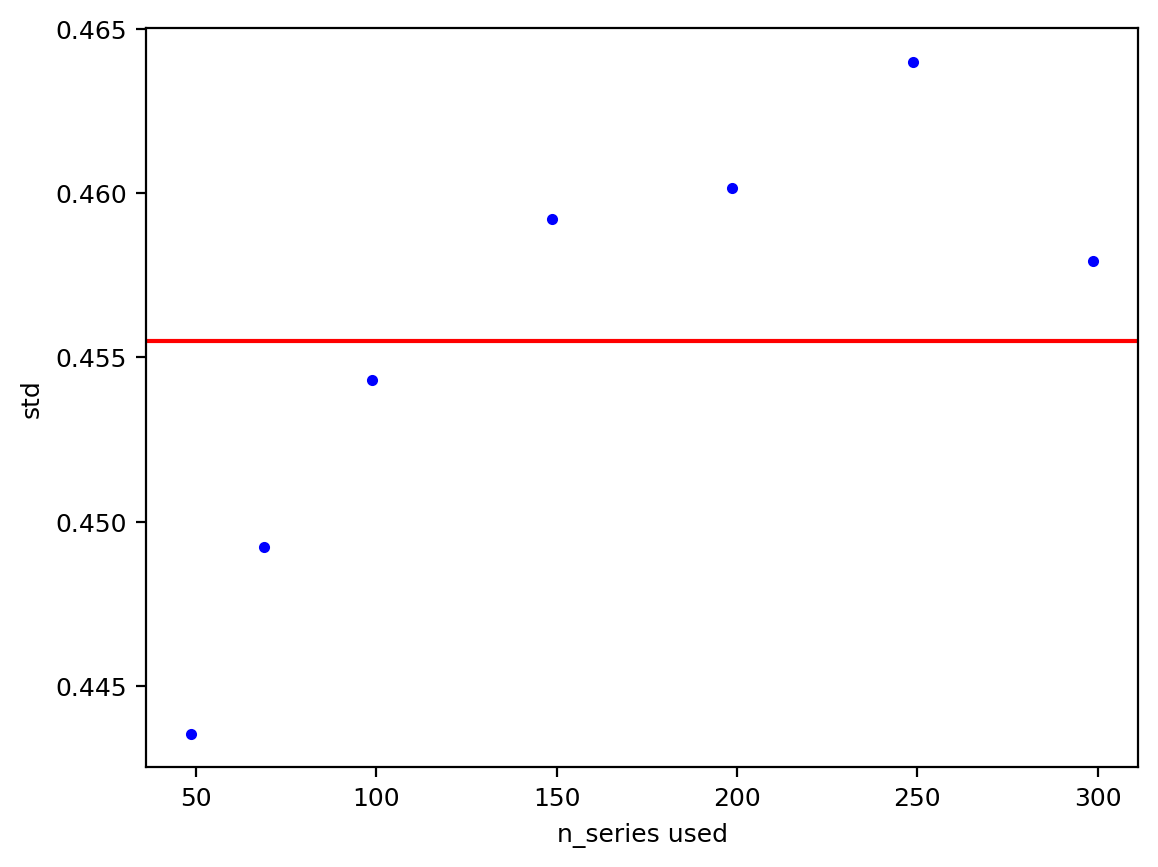

In [8]:
# get the mean value for each group
grouped_mean = df_rand[df_rand['n_series'] >= 50].groupby('n_series').mean()
grouped_std = df_rand[df_rand['n_series'] >= 50].groupby('n_series').std()

# estimate the std (which however, uses the n_series_used, the actual number of series used)
x = grouped_mean['n_series_used']
std = (x-2) / (x*np.sqrt(x-1))
normalized = grouped_std['acf'].values / std

# least squares
gamma = np.mean(normalized)
print('gamma (random_idx) = ', gamma)


plt.plot(x, normalized, color='blue', marker='o', linestyle='', markersize=3)
plt.axhline(y=gamma, color='red')

plt.xlabel("n_series used")
plt.ylabel("std")

In [9]:
mac_mean_const = []
mac_mean_rand = []
used_n_series_const = []
used_n_series_rand = []

mac_std_rand = []
mac_std_const = []

for n_s in n_series:
    # filter the dataframe for n_s
    df_n_s = df_const[df_const['n_series'] == n_s]
    mac_mean_const.append(df_n_s['acf'].mean())
    used_n_series_const.append(df_n_s['n_series_used'].mean())
    mac_std_const.append(df_n_s['acf'].std())

    df_n_s = df_rand[df_rand['n_series'] == n_s]
    mac_mean_rand.append(df_n_s['acf'].mean())
    used_n_series_rand.append(df_n_s['n_series_used'].mean())
    mac_std_rand.append(df_n_s['acf'].std())

# theoretical mean & std
x = np.array(used_n_series_const)
mean_th_const = -1/x
std_th_const = 0.81 * (x-2) / (x*np.sqrt(x-1))

x = np.array(used_n_series_rand)
mean_th_rand = -1/x
std_th_rand = 0.46 * (x-2) / (x*np.sqrt(x-1))

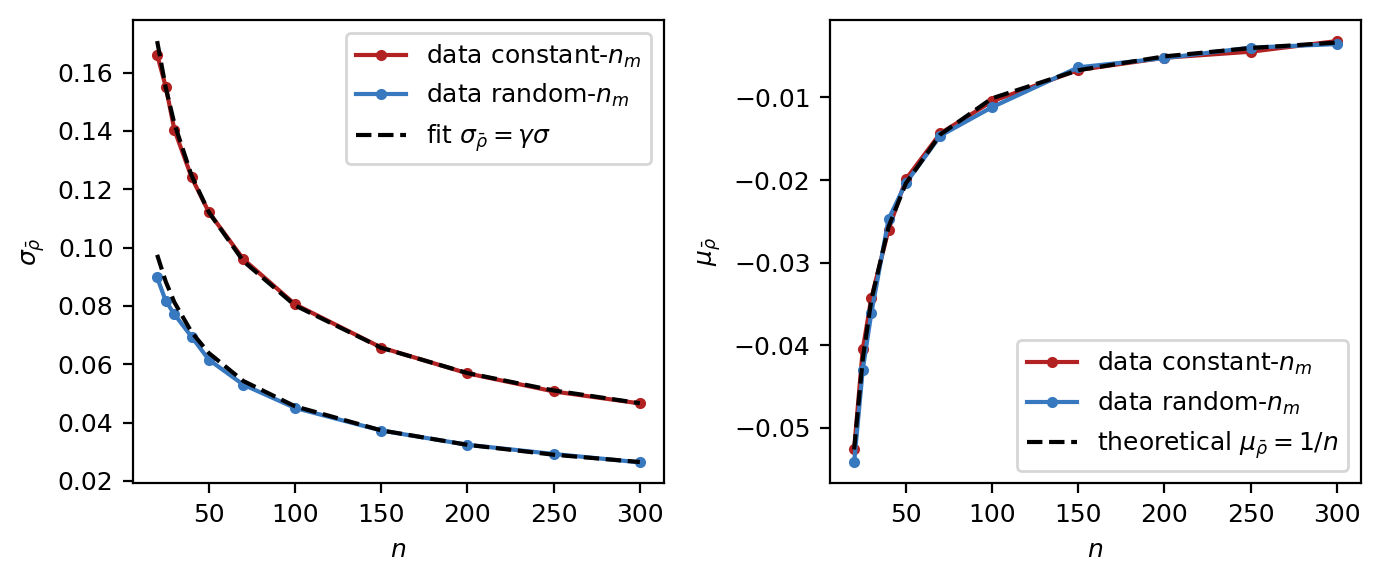

In [10]:
# Create a figure
plt.rcParams.update({'font.size': 9})

fig, axs = plt.subplots(1, 2, figsize=(7, 3))

n_series= np.array(n_series)
sigma_const = np.array(std_th_const)
sigma_rand = np.array(std_th_rand)
acf_std_const = np.array(mac_std_const)
acf_std_rand = np.array(mac_std_rand)
acf_mean_const = np.array(mac_mean_const)
acf_mean_rand = np.array(mac_mean_rand)
idx =n_series > 15

axs[0].plot(n_series[idx], acf_std_const[idx], 'firebrick', label='data constant-$n_m$', marker='o', markersize=3)

axs[0].plot(n_series[idx], acf_std_rand[idx], '#3778bf',label='data random-$n_m$', marker='o', markersize=3)
axs[0].plot(n_series[idx], sigma_rand[idx], 'k--')
axs[0].plot(n_series[idx], sigma_const[idx], 'k--', label=r'fit $\sigma_{\bar\rho} = \gamma  \sigma$')


axs[0].legend()
axs[0].set_xlabel('$n$')
axs[0].set_ylabel(r'$\sigma_{\bar \rho}$')


axs[1].plot(n_series[idx], acf_mean_const[idx], 'firebrick', label='data constant-$n_m$', marker='o', markersize=3)
axs[1].plot(n_series[idx], acf_mean_rand[idx], '#3778bf', label='data random-$n_m$', marker='o', markersize=3)
axs[1].plot(n_series[idx], mean_th_const[idx], 'k--', label=r'theoretical $\mu_{\bar\rho} = 1/n $')

axs[1].legend()
axs[1].set_xlabel('$n$')
axs[1].set_ylabel(r'$\mu_{\bar \rho}$')

plt.tight_layout()

# Fig S4: Length scale analysis details -> see length_scale_IG.ipynb